In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


from sklearn.linear_model import LinearRegression

In [9]:
data = pd.read_csv('/home/user/avocado.csv').iloc[:, 1:]
data["Date"] = pd.to_datetime(data["Date"])
data

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [10]:
summarized = data[["Date", "region", "AveragePrice", "Total Volume"]].groupby(["Date", "region"]).mean().reset_index()
nominal = summarized.groupby("region")[["AveragePrice", "Total Volume"]].transform("median")
summarized["priceDelta"] = (summarized["AveragePrice"] - nominal["AveragePrice"]) / nominal["AveragePrice"]
summarized["demandDelta"] = (summarized["Total Volume"] - nominal["Total Volume"]) / nominal["Total Volume"]
summarized["Month"] = summarized["Date"].dt.month_name()
summarized["Season"] = summarized["Month"].replace({
    'January': "Winter", 
    'February': "Winter", 
    'March': "Spring", 
    'April': "Spring", 
    'May': "Spring", 
    'June': "Summer", 
    'July': "Summer",
    'August': "Summer", 
    'September': "Fall", 
    'October': "Fall", 
    'November': "Fall", 
    'December': "Winter"
})
summarized["Year"] = summarized["Date"].dt.year

us_reg = summarized["region"] == "Total US"
us_summary = summarized[us_reg]
summarized = summarized[~us_reg]

Median Price: $1.39. Median Demand 205.3K


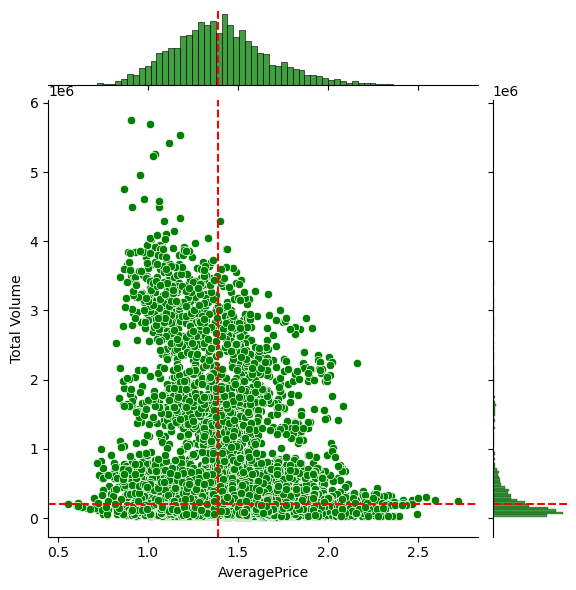

In [11]:
price_med = summarized["AveragePrice"].median()
demand_med = summarized["Total Volume"].median()
h = sns.jointplot(data=summarized, x="AveragePrice", y="Total Volume", color="green")
h.refline(
    x=price_med,
    y=demand_med, 
    color="red")
print(f"Median Price: ${price_med:.2f}. Median Demand {demand_med/1E3:.1f}K")

In [12]:
summarized["region"].value_counts().shape


(53,)

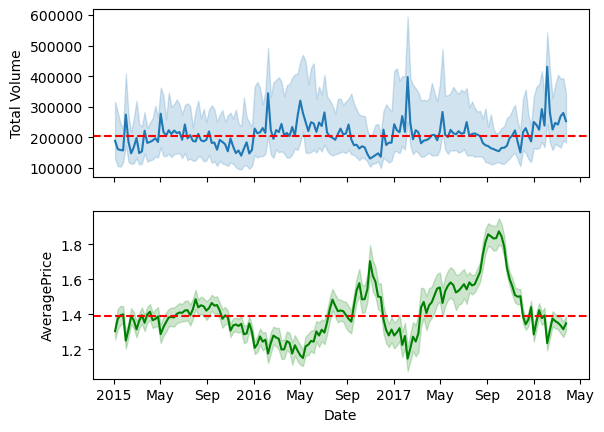

In [13]:
fig, (axd, axp) = plt.subplots(2, 1)
sns.lineplot(data=summarized, x="Date", y="Total Volume", estimator=np.median, ax=axd)
sns.lineplot(data=summarized, x="Date", y="AveragePrice", color="green", ax=axp)

axp.axhline(price_med, ls="--", color="r")

axd.set_xticklabels([])
axd.set_xlabel('')
axp.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(axp.xaxis.get_major_locator()))
axd.axhline(demand_med, ls="--", color="r")

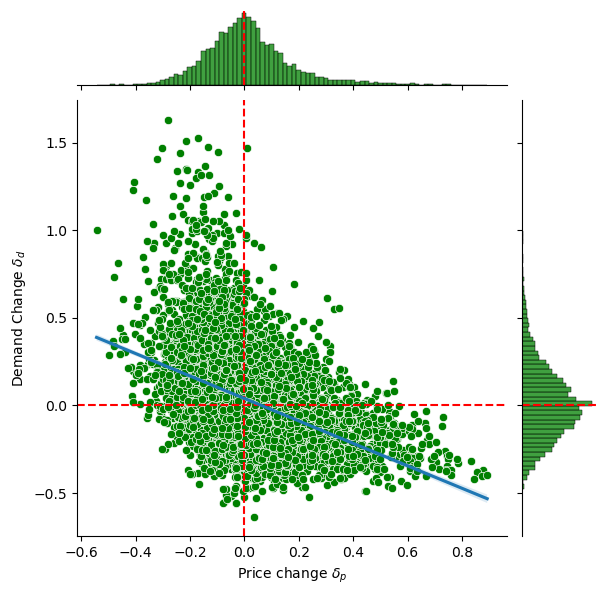

In [14]:
g = sns.jointplot(data=summarized, x="priceDelta", y="demandDelta", color="green")
g.refline(
    x=summarized["priceDelta"].median(),
    y=summarized["demandDelta"].median(), 
    color="red")
sns.regplot(data=summarized, x="priceDelta", y="demandDelta", scatter=False, ax=g.ax_joint)
g.ax_joint.set(
    xlabel=r"Price change $\delta_p$",
    ylabel=r"Demand Change $\delta_d$"
);

In [15]:
lm = LinearRegression()
lm.fit(summarized["priceDelta"].values.reshape(-1, 1), summarized["demandDelta"])
lm.coef_

array([-0.64160951])

In [16]:
lm = LinearRegression()
names = []
elasticity = []
g = summarized.groupby("region")
for name, group in g:
    lm.fit(group["priceDelta"].values.reshape(-1, 1), group["demandDelta"])
    elasticity.append(lm.coef_)
    names.append(name)
elasticity = np.array(elasticity)
elasticity = pd.Series(elasticity.reshape(-1), index=np.array(names))
elasticity = elasticity.sort_values()
elasticity.name = "Elasticity"

In [17]:
elasticity.describe()

count    53.000000
mean     -0.694153
std       0.331196
min      -2.226560
25%      -0.866360
50%      -0.662013
75%      -0.549415
max      -0.009798
Name: Elasticity, dtype: float64

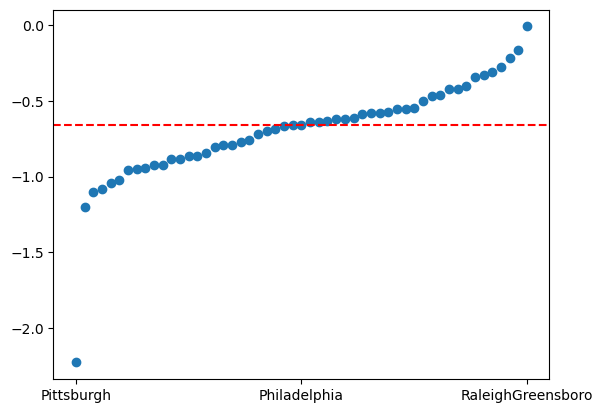

In [18]:
plt.plot(elasticity, 'o')
plt.xticks([0, 53//2, 52])
plt.axhline(elasticity.median(), ls="--", color="red")

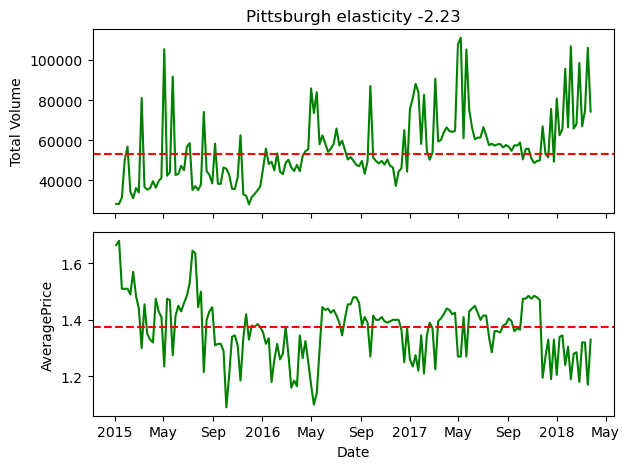

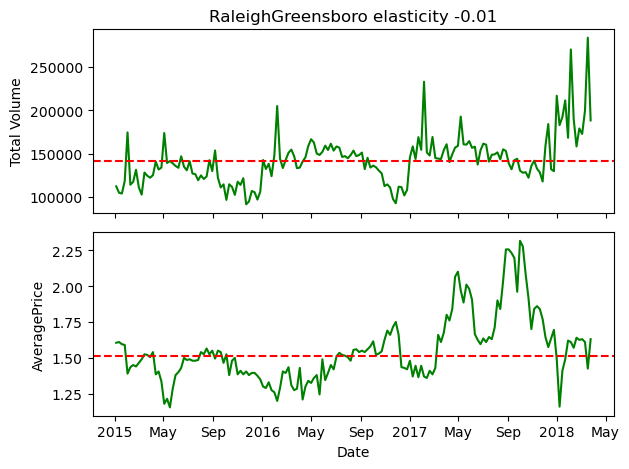

In [19]:
for region in elasticity.index[[0, -1]]:
    regions = summarized[summarized["region"] == region]

    fig, (axd, axp) = plt.subplots(2, 1, tight_layout=True)
    sns.lineplot(data=regions, x="Date", y="Total Volume", color="green", estimator=np.median, ax=axd)
    sns.lineplot(data=regions, x="Date", y="AveragePrice", color="green", ax=axp)

    axd.set_title(f"{region} elasticity {elasticity.loc[region]:.2f}")
    
    axd.axhline(regions["Total Volume"].median(), ls="--", color="r")
    axp.axhline(regions["AveragePrice"].median(), ls="--", color="r")

    axd.set_xticklabels([])
    axd.set_xlabel('')
    axp.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(axp.xaxis.get_major_locator()))

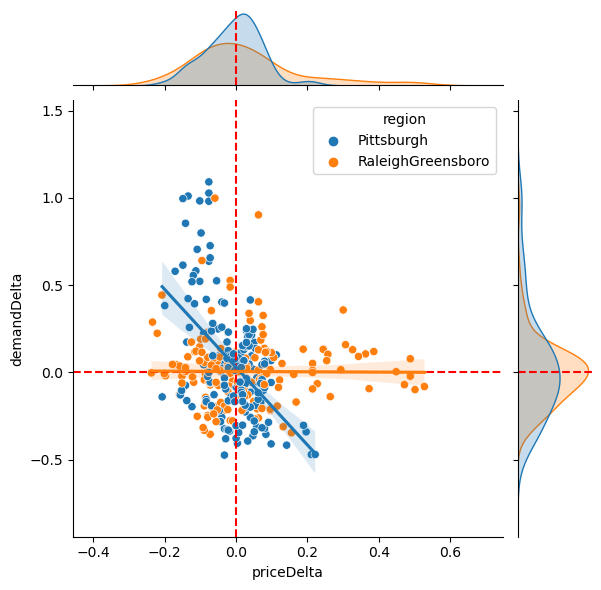

In [20]:
regions = summarized[np.logical_or(
    summarized["region"] == elasticity.index[0],
    summarized["region"] == elasticity.index[-1])]

g = sns.jointplot(data=regions, x="priceDelta", y="demandDelta", hue="region")
g.refline(
    x=regions["priceDelta"].median(),
    y=regions["demandDelta"].median(), 
    color="red")
g.ax_joint.set(
    xlabel=r"Price change $\delta_p$",
    ylabel=r"Demand Change $\delta_d$"
);

for _, region in regions.groupby("region"):
    sns.regplot(data=region, x="priceDelta", y="demandDelta", scatter=False, ax=g.ax_joint)